In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Загрузка данных из CSV файла
file_path = 'data/preprocessed_products.csv'
data = pd.read_csv(file_path)

# Преобразование True в 1 и False в 0
# Применяем astype(int) ко всем столбцам, где есть булевые значения
data = data.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)

# Разделение данных на тренировочную и тестовую части (70% - 30%)
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Сохранение тренировочного и тестового наборов в новые CSV файлы
train_data.to_csv('data/training.csv', index=False)
test_data.to_csv('data/test.csv', index=False)

print("Данные успешно обработаны и сохранены в 'training.csv' и 'test.csv'.")



Лучшие гиперпараметры: k=1, metric=euclidean, kernel=uniform, accuracy=0.007936507936507936


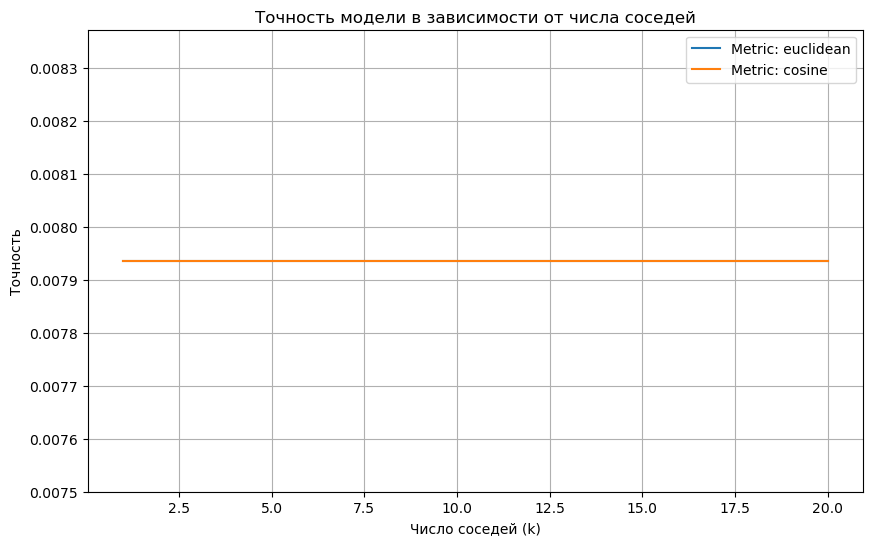

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from models.kNN import KNearestNeighbors

# 1. Загрузка данных
data = pd.read_csv('data/training.csv')

# Предположим, что целевая переменная - это 'Название товара' (или другой столбец)
# Отделим признаки и целевую переменную
X = data.drop(columns=['Цена'])  # Замените на фактическое название целевой переменной
y = data['Цена']  # Измените на целевую переменную

# Нормализация данных
X = (X - X.mean()) / X.std()

# 2. Перебор гиперпараметров
k_values = range(1, 21)  # Например, от 1 до 20
metrics = ['euclidean', 'cosine']  # Метрики расстояния
kernels = ['uniform', 'gaussian']  # Типы ядер

# Хранение результатов
results = []

# Разделяем данные на тренировочный и тестовый наборы
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Перебор комбинаций гиперпараметров
for k in k_values:
    for metric in metrics:
        for kernel in kernels:
            # Создаем и обучаем модель
            knn = KNearestNeighbors(k=k, metric=metric, kernel=kernel)
            knn.fit(X_train, y_train)

            # Предсказание на валидационном наборе
            y_pred = knn.predict(X_val)

            # Оценка качества (например, точность)
            accuracy = np.mean(y_pred == y_val)

            # Сохраняем результаты
            results.append((k, metric, kernel, accuracy))

# 3. Определяем лучшие гиперпараметры
best_params = max(results, key=lambda x: x[3])  # max по точности
print("Лучшие гиперпараметры: k={}, metric={}, kernel={}, accuracy={}".format(*best_params))

# 4. Построение графика зависимости
# Для примера, график зависимости точности от числа соседей для фиксированных метрик и ядер
accuracies = {k: [] for k in k_values}

for k in k_values:
    for metric in metrics:
        for kernel in kernels:
            # Обучение
            knn = KNearestNeighbors(k=k, metric=metric, kernel=kernel)
            knn.fit(X_train, y_train)

            # Предсказание и оценка
            y_pred = knn.predict(X_val)
            accuracy = np.mean(y_pred == y_val)
            accuracies[k].append(accuracy)

# График
plt.figure(figsize=(10, 6))
for metric in metrics:
    plt.plot(k_values, [accuracies[k][0] for k in k_values], label=f'Metric: {metric}')

plt.title('Точность модели в зависимости от числа соседей')
plt.xlabel('Число соседей (k)')
plt.ylabel('Точность')
plt.legend()
plt.grid()
plt.show()


In [4]:
import numpy as np
from scipy.spatial.distance import cosine


class KNearestNeighbors:
    def __init__(self, k=3, window_size=None, metric='euclidean', kernel='uniform', weights=None):
        self.k = k
        self.window_size = window_size
        self.metric = metric
        self.kernel = kernel
        self.weights = weights

    def _uniform_kernel(self, distances):
        return np.where(distances <= 1, 1, 0)

    def _gaussian_kernel(self, distances):
        return np.exp(-0.5 * (distances ** 2))

    def _general_kernel(self, distances, a, b):
        return np.power(1 - np.abs(distances) ** a, b)

    def _calculate_weights(self, distances):
        if self.kernel == 'uniform':
            return self._uniform_kernel(distances)
        elif self.kernel == 'gaussian':
            return self._gaussian_kernel(distances)
        else:
            raise ValueError("Unknown kernel type.")

    def _distance(self, x, y):
        if self.metric == 'cosine':
            return cosine(x, y)
        elif self.metric == 'euclidean':
            return np.linalg.norm(x - y)
        elif self.metric.startswith('minkowski'):
            p = float(self.metric.split('_')[1])  # Lp, где p передается в строке
            return np.linalg.norm(x - y, ord=p)
        else:
            raise ValueError("Unknown distance metric.")

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        X = np.array(X)
        predictions = []
        for x in X:
            # Вычисляем расстояния до всех обучающих объектов
            distances = np.array([self._distance(x, x_train) for x_train in self.X_train])
            sorted_indices = np.argsort(distances)
            neighbors_indices = sorted_indices[:self.k]

            # Веса для соседей
            weights = self._calculate_weights(distances[neighbors_indices])

            # Применяем веса
            if self.weights is not None:
                weights *= self.weights[:self.k]

            # Прогнозируем класс
            class_votes = {}
            for idx, weight in zip(neighbors_indices, weights):
                label = self.y_train[idx]
                if label not in class_votes:
                    class_votes[label] = 0
                class_votes[label] += weight

            # Находим класс с максимальным весом
            predicted_class = max(class_votes, key=class_votes.get)
            predictions.append(predicted_class)
        return np.array(predictions)

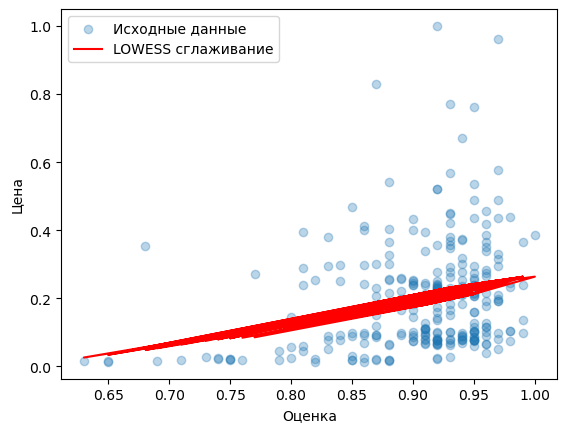

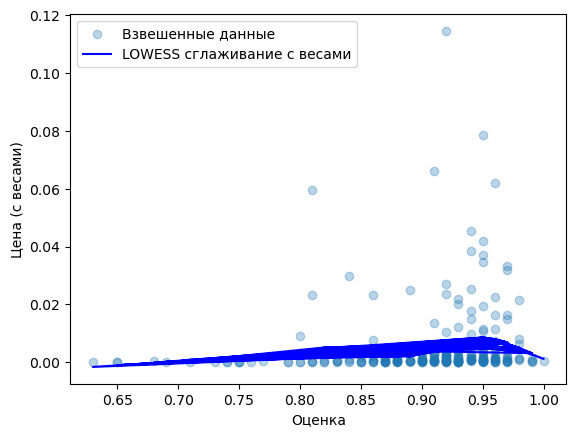

MSE до взвешивания: 0.018023009462465087
MSE после взвешивания: 0.05397069545295974


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# Функция для вычисления весов
def tricube_weight(d, h, epsilon=1e-5):
    # Добавляем небольшую константу epsilon для предотвращения деления на ноль
    w = np.clip(1 - (d / (h + epsilon)) ** 3, 0, 1) ** 3
    return w


# Реализация LOWESS с нуля
def lowess(x, y, frac=0.3, it=3, epsilon=1e-5):
    n = len(x)
    r = int(np.ceil(frac * n))  # Количество точек для локальной регрессии
    y_smoothed = np.zeros(n)

    # Для каждой точки в данных
    for i in range(n):
        # Рассчитываем расстояние до всех других точек
        distances = np.abs(x - x[i])

        # Определяем окно окрестности по frac
        h = np.sort(distances)[r]
        weights = tricube_weight(distances, h, epsilon)

        # Местная регрессия с весами
        W = np.diag(weights)
        X_design = np.vstack([np.ones(n), x]).T

        # Проверяем, чтобы матрица не была сингулярной
        try:
            beta = np.linalg.pinv(X_design.T @ W @ X_design) @ (X_design.T @ W @ y)
        except np.linalg.LinAlgError:
            beta = np.array([np.nan, np.nan])  # Если матрица сингулярна, просто пропускаем точку

        # Получаем предсказанное значение для текущей точки
        y_smoothed[i] = beta[0] + beta[1] * x[i]

    return y_smoothed


# Загрузка данных
train_data = pd.read_csv('data/training.csv')
test_data = pd.read_csv('data/test.csv')

# Пример признака для аномалий (используем оценку и цену)
X_train = train_data['Оценка'].values
Y_train = train_data['Цена'].values

# Проверка данных на пропуски и некорректные значения
train_data = train_data.dropna()
train_data = train_data[(train_data['Оценка'] > 0) & (train_data['Цена'] > 0)]
X_train = train_data['Оценка'].values
Y_train = train_data['Цена'].values

# Применение LOWESS без весов
smoothed = lowess(X_train, Y_train, frac=0.3)

# Построение графика
plt.scatter(X_train, Y_train, label='Исходные данные', alpha=0.3)
plt.plot(X_train, smoothed, color='red', label='LOWESS сглаживание')

# Подписывание осей
plt.xlabel('Оценка')
plt.ylabel('Цена')
plt.legend()
plt.show()

# Взвешивание данных (например, на основе количества оценок)
weights = train_data['Кол-во оценок'].values
weights[weights == 0] = 0.000001  # Избежание нулевых весов

# Применение сглаживания с весами
weighted_Y_train = Y_train * weights
smoothed_weighted = lowess(X_train, weighted_Y_train, frac=0.3)

# Построение графика с весами
plt.scatter(X_train, weighted_Y_train, label='Взвешенные данные', alpha=0.3)
plt.plot(X_train, smoothed_weighted, color='blue', label='LOWESS сглаживание с весами')

# Подписывание осей
plt.xlabel('Оценка')
plt.ylabel('Цена (с весами)')
plt.legend()
plt.show()

# Применение на тестовом множестве
X_test = test_data['Оценка'].values
Y_test = test_data['Цена'].values
smoothed_test = lowess(X_test, Y_test, frac=0.3)

# Оценка качества модели (до и после взвешивания)
mse_before = mean_squared_error(Y_test, smoothed_test)

# Взвешивание на тестовых данных
test_data = test_data.dropna()
weights_test = test_data['Кол-во оценок'].values
weights_test[weights_test == 0] = 0.00001  # Избежание нулевых весов
weighted_Y_test = Y_test * weights_test
smoothed_test_weighted = lowess(X_test, weighted_Y_test, frac=0.3)

mse_after = mean_squared_error(Y_test, smoothed_test_weighted)

print(f'MSE до взвешивания: {mse_before}')
print(f'MSE после взвешивания: {mse_after}')
